# Recovery of gold from ore

The goal of the project is to create a model that predicts the recovery rate of gold from gold-bearing ore. The data available includes parameters related to the mining and processing stages. The model aims to optimize production by identifying and avoiding unprofitable operating conditions.

The processing process consists of three stages: flotation, primary cleaning, and secondary cleaning.

The dataset contains various parameters for each cleaning stage.

## Data preparation

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
import random
import scipy.stats as st
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

In [4]:
data_full = pd.read_csv('gold_recovery_full_new.csv')
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')

Let's check what signs are in the samples

In [5]:
len(data_full.columns)

87

In [6]:
len(data_train.columns)

87

In [7]:
len(data_test.columns)

53

In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

From the given context, it is mentioned that data_full contains both datasets. Therefore, let's examine it to verify if the calculation of recovery is correct and identify which features correlate with the target variable, among other things.

First, let's count the missing values and duplicates.

In [11]:
pd.set_option('display.max_rows', None)
data_full.isna().sum().to_frame()

,0
date,0
final.output.concentrate_ag,1
final.output.concentrate_pb,1
final.output.concentrate_sol,211
final.output.concentrate_au,0
final.output.recovery,0
final.output.tail_ag,1
final.output.tail_pb,101
final.output.tail_sol,6
final.output.tail_au,0


In [12]:
pd.reset_option('display.max_rows')

In [13]:
data_full.duplicated().sum()

0

In general, the data is fairly complete and there are no duplicates. The only notable issue is with the secondary_cleaner.output.tail_sol column, which has 1748 missing values. However, we will further investigate if this column is necessary for prediction.

But first, let's verify if the calculation of recovery is correct.

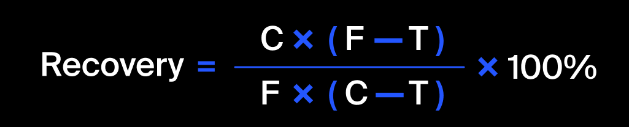

In [14]:
def recovery(per_before, per_after, per_tail):
    """
    The function calculate recovery for ore. Using percentage of metal before, after and in tails 
    """
    rec = per_after * (per_before - per_tail) / (per_before * (per_after - per_tail)) * 100
    return rec

In [15]:
rec = recovery(data_full['rougher.input.feed_au'], data_full['rougher.output.concentrate_au'], data_full['rougher.output.tail_au'])

In [16]:
mean_absolute_error(data_full['rougher.output.recovery'], rec)

9.874045668302637e-15

The difference in recovery is negligibly small, indicating that the calculation is correct.

Let's check the features that are missing in the test set.

In [17]:
(set(data_full.columns) - set(data_test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The test set lacks information on the outputs of the reactions after the cleaning stages and data on the chemicals used. Most importantly, the target variables are missing in these features. We can restore them using the date information.

In [18]:
data_test = data_test.merge(data_full[['date','rougher.output.recovery','final.output.recovery']],how='left',on='date')

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Now let's explore the distribution of features, starting with studying the correlation.

In [20]:
f = data_full.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
t = data_full[['rougher.output.recovery','final.output.recovery']]

In [21]:
f.columns[f.columns.str.contains('final')]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au'],
      dtype='object')

interval columns not set, guessing: ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'rougher.output.recovery', 'final.output.recovery']


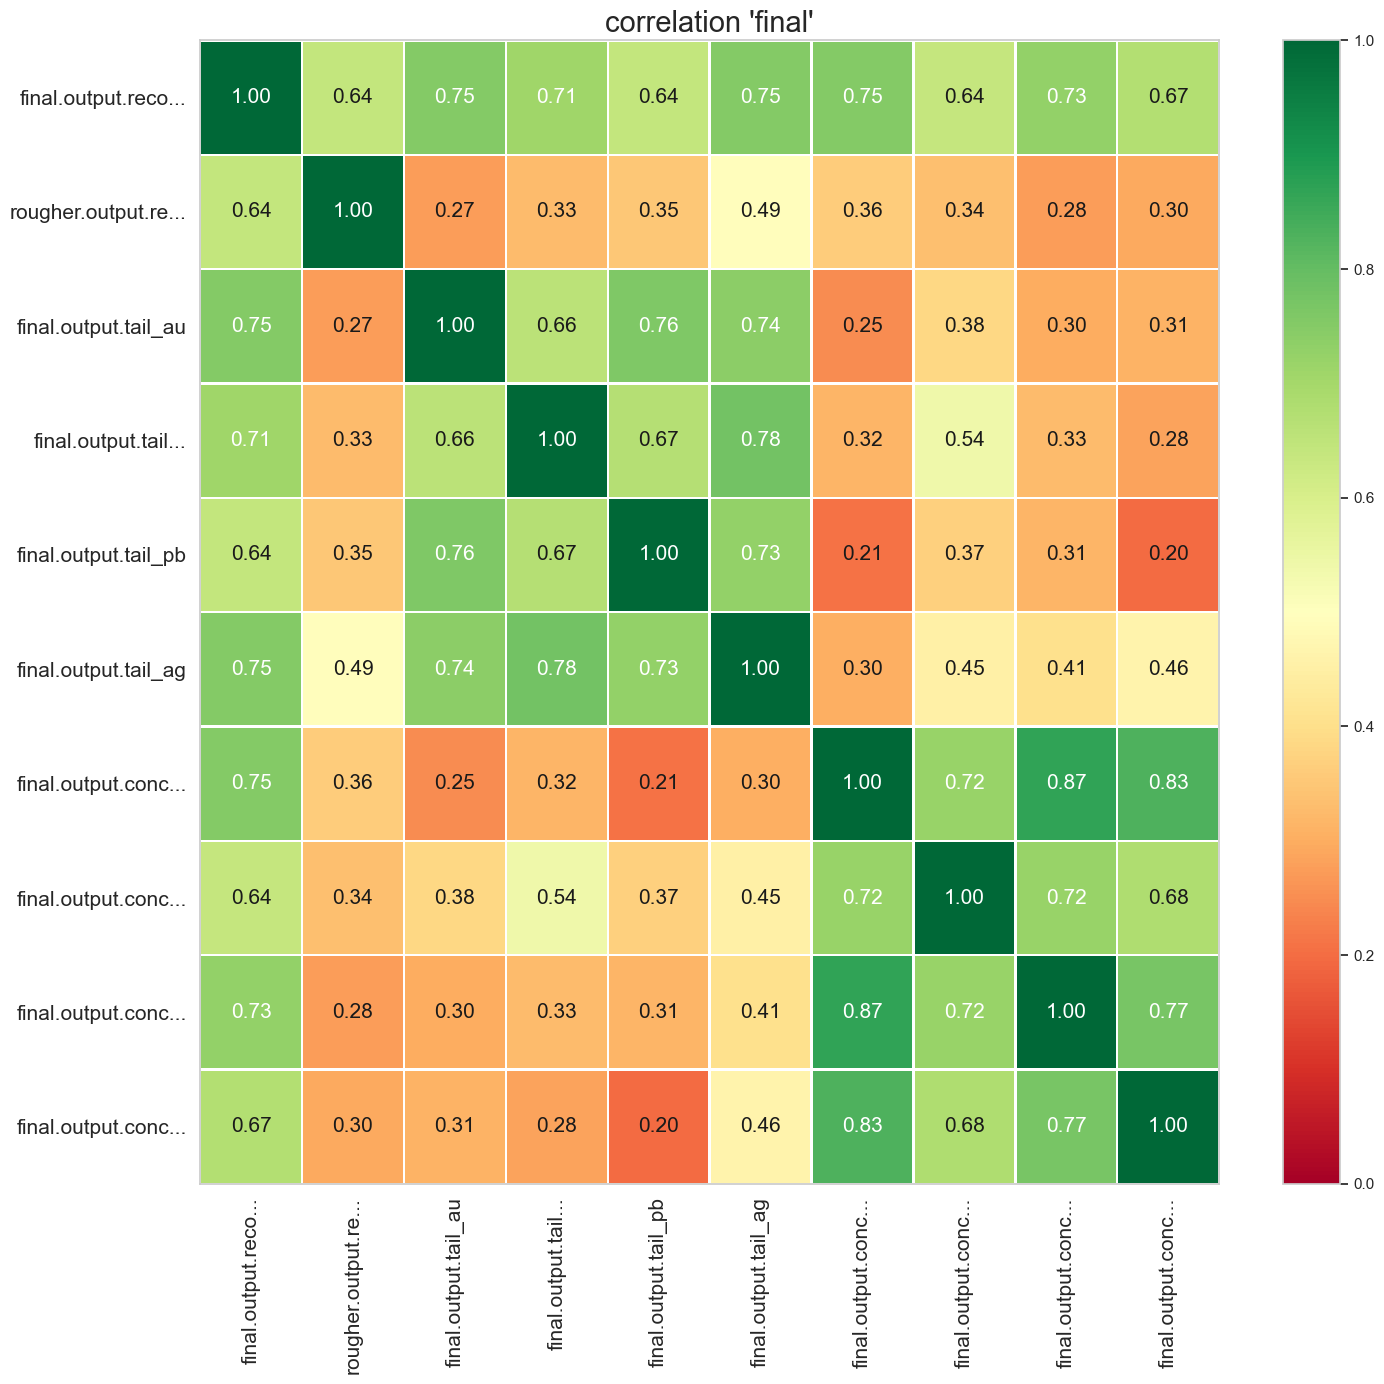

In [22]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('final')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'final'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.output.recovery', 'final.output.recovery']


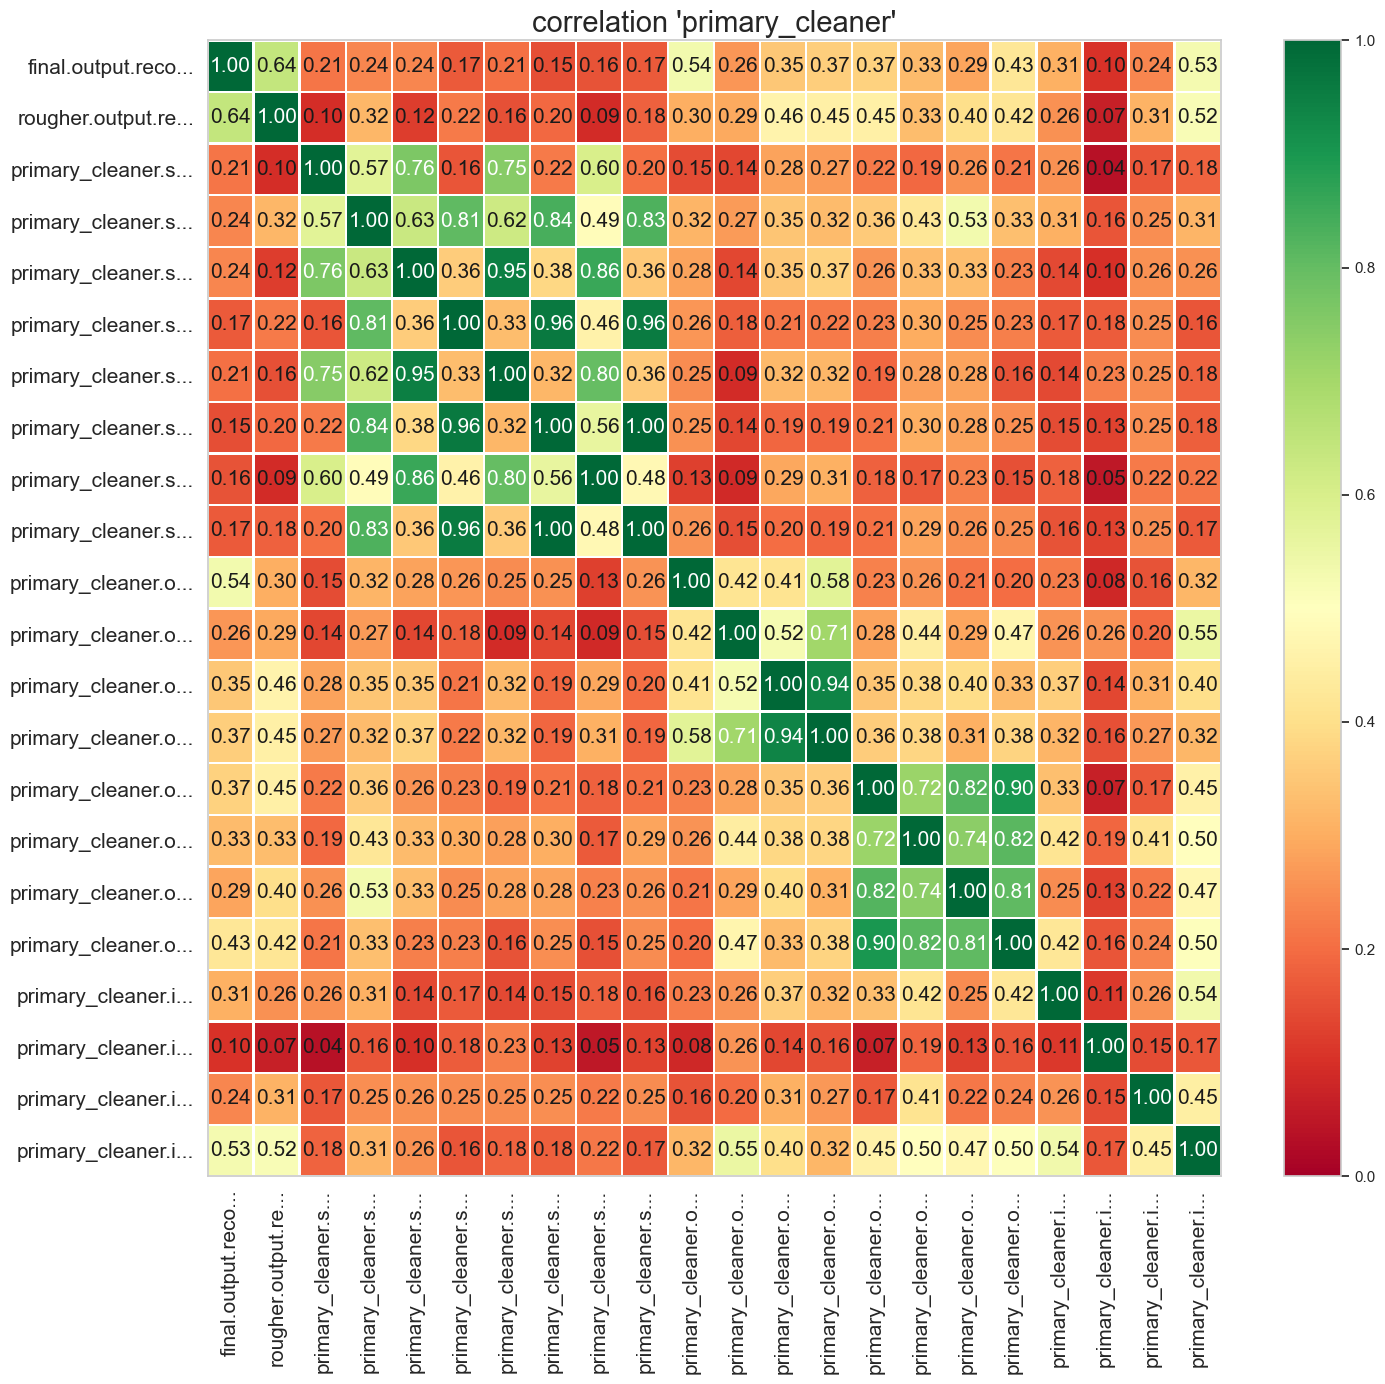

In [23]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('primary_cleaner')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au', 'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level', 'rougher

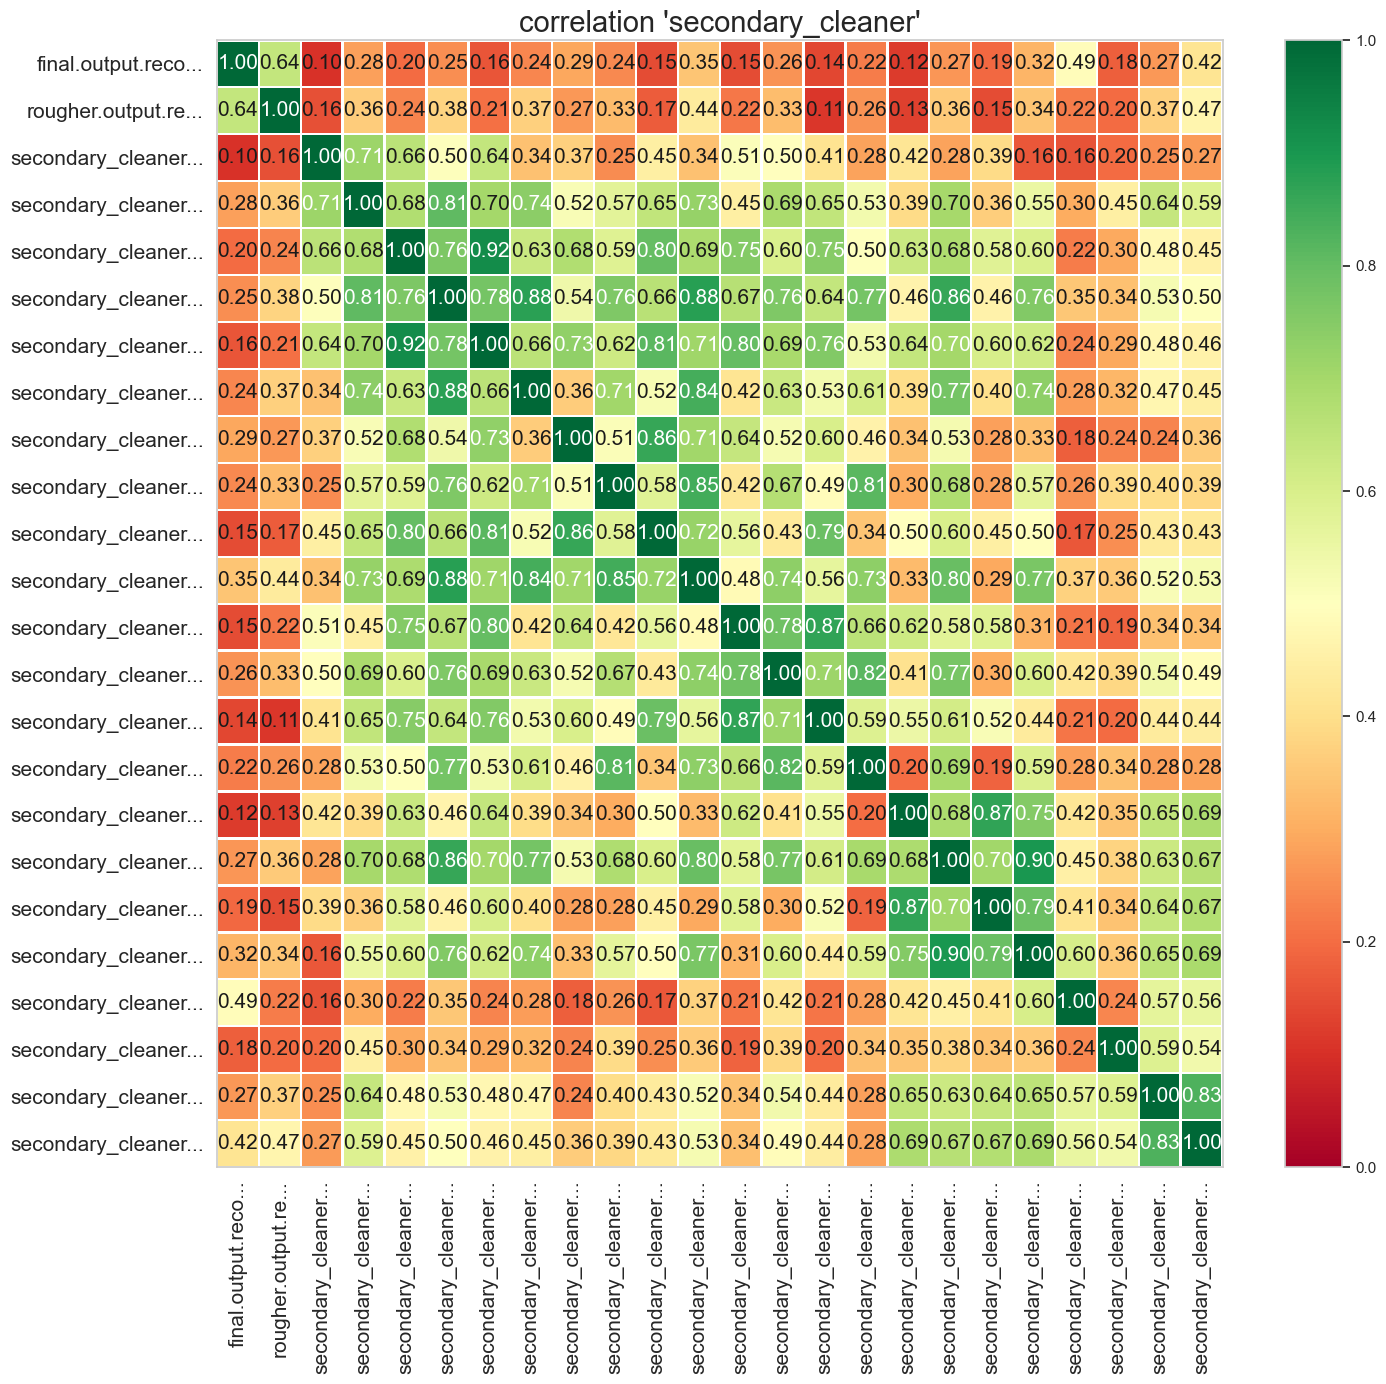

In [24]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('secondary_cleaner')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'secondary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

interval columns not set, guessing: ['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.sta

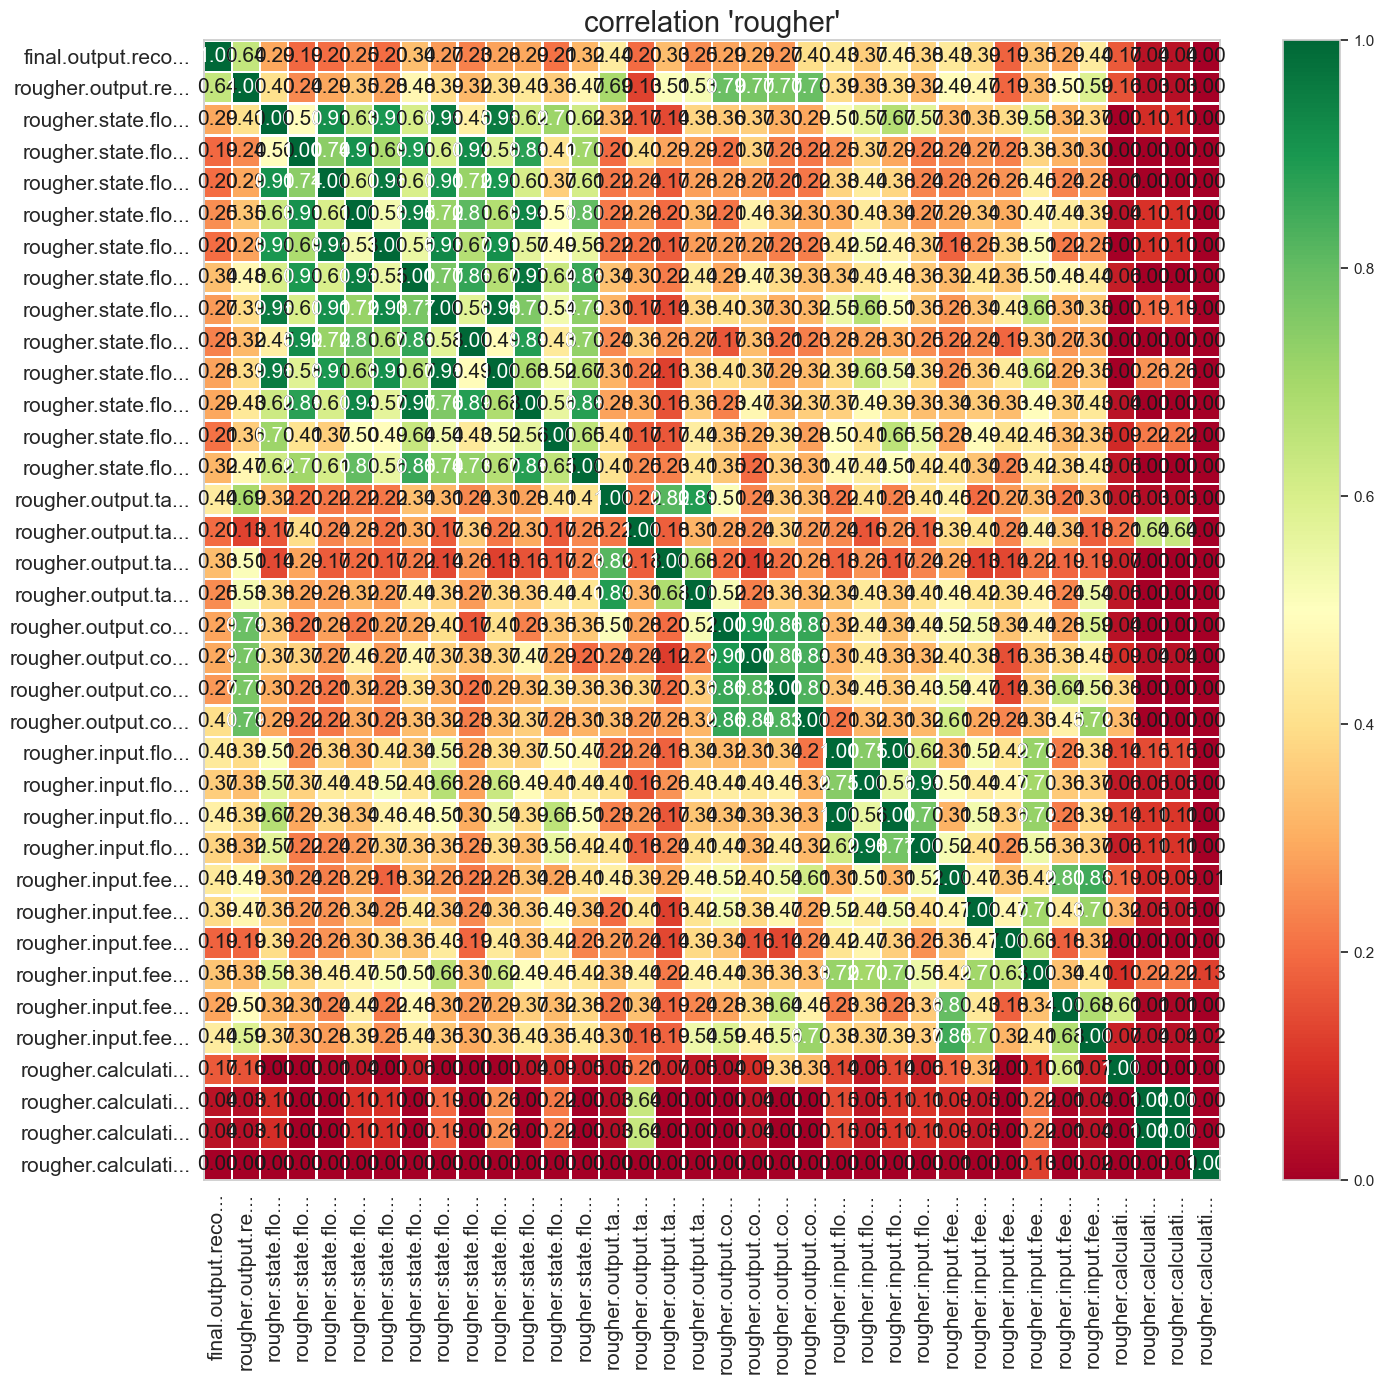

In [25]:
phik_overview = pd.concat([f[f.columns[f.columns.str.contains('rougher')]],t],axis=1).phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation 'rougher'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

We see that some signs are very strongly correlated, so we need to take this into account when selecting them for training. Secondly, since there is no part of the features in the test sample, we will also remove them from the general and training samples (due to leakage of the target feature). We will also delete all the omissions, they are less than 10%, so deletion is acceptable

In [26]:
data_full.dropna(inplace=True)
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)

In [27]:
df_full = data_full[data_test.columns]
df_train = data_train[data_test.columns]
df_test = data_test[data_test.columns]

Next step is a preparation the data for training. To exit the reaction after flotation, we can use the data only before this process, therefore, only the parameters of the raw material and the state, that is, rougher.input and rougher.state. By analogy, we will also do it for the final sample, also take into account that the signs of rougher.calculation almost do not correlate with the target signs.

In [28]:
index_rougher = df_train.columns[df_train.columns.str.contains('rougher.input|rougher.state|data')]
features_rougher = df_train[index_rougher]
target_rougher = df_train[['rougher.output.recovery']]
features_rougher_test = df_test[index_rougher]
target_rougher_test = df_test[['rougher.output.recovery']]

In [29]:
index_final = df_train.columns[df_train.columns.str.contains('final.output|date')]
features = df_train.drop(index_final,axis=1)
target = df_train[['final.output.recovery']]
features_test = df_test.drop(index_final,axis=1)
target_test = df_test[['final.output.recovery']]

## Dara analysis

Let's plot the distributions of metal concentrations after different stages of purification.

In [30]:
l = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
metal_list = ['ag','pb','au']
color = ['yellow','']

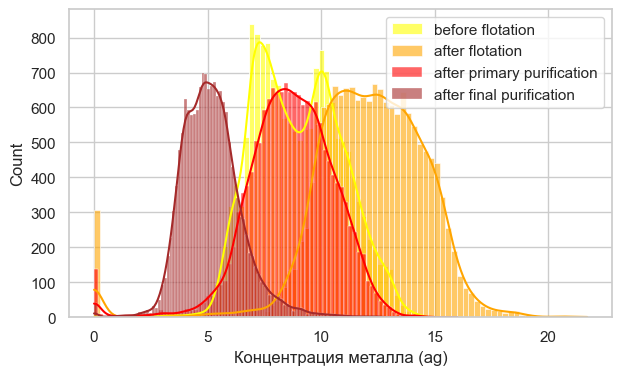

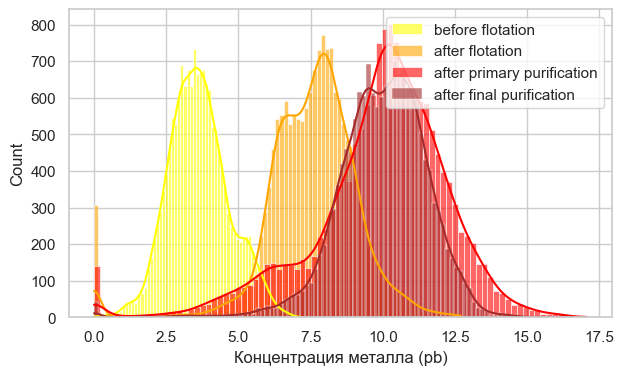

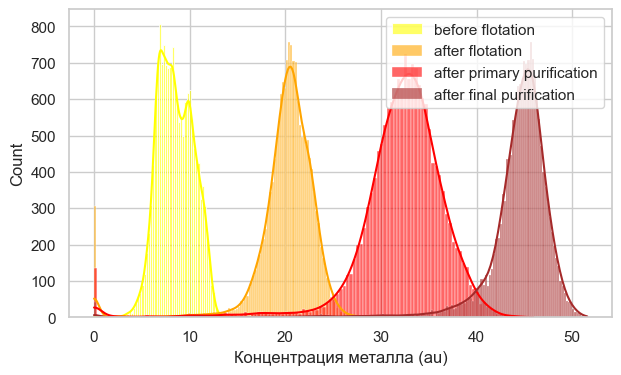

In [66]:
for metal in metal_list:
    plt.figure(figsize=(7, 4))
    sns.histplot(data_full,x=l[0]+metal,label='before flotation',color='yellow',kde=True,alpha=.6)
    sns.histplot(data_full,x=l[1]+metal,label='after flotation',color='orange',kde=True,alpha=.6)
    sns.histplot(data_full,x=l[2]+metal,label='after primary purification',color='red',kde=True,alpha=.6)
    sns.histplot(data_full,x=l[3]+metal,label='after final purification',color='brown',kde=True,alpha=.6)
    plt.xlabel(f'Концентрация металла ({metal})')
    plt.legend()
    plt.show()

**Conclusion: Only the concentration of gold increases during the purification process, by a factor of 5. The concentration of lead does not increase after primary purification, and the concentration of silver decreases after the entire cycle. It is also evident that there are peaks around zero concentrations after processing. These peaks may be due to improper chemical processes, which should be taken into account in the model, or they may reflect the probability of empty ore. Therefore, we will keep them in the dataset.**

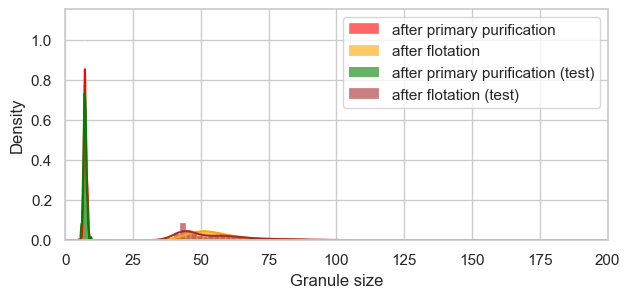

In [65]:
size = f.columns[f.columns.str.contains('size')]
plt.figure(figsize=(7,3))
sns.histplot(data_train,x=size[0],label='after primary purification',color='red',kde=True,alpha=.6,stat='density')
sns.histplot(data_train,x=size[1],label='after flotation',color='orange',kde=True,alpha=.6,stat='density')
sns.histplot(data_test,x=size[0],label='after primary purification (test)',color='green',kde=True,alpha=.6,stat='density')
sns.histplot(data_test,x=size[1],label='after flotation (test)',color='brown',kde=True,alpha=.6,stat='density')
plt.xlabel('Granule size')
plt.legend()
plt.xlim([0,200])
plt.show()

In [33]:
f.columns[f.columns.str.contains('size')]

Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')

In [34]:
st.ttest_ind(data_train['primary_cleaner.input.feed_size'],data_test['primary_cleaner.input.feed_size'])

Ttest_indResult(statistic=12.66490737306463, pvalue=1.3779981880710514e-36)

In [35]:
st.ttest_ind(data_train['rougher.input.feed_size'],data_test['rougher.input.feed_size'])

Ttest_indResult(statistic=4.253987977556823, pvalue=2.1117214581598514e-05)

**Conclusion: the size of granules in the test and training samples are statistically indistinguishable**

<Figure size 700x400 with 0 Axes>

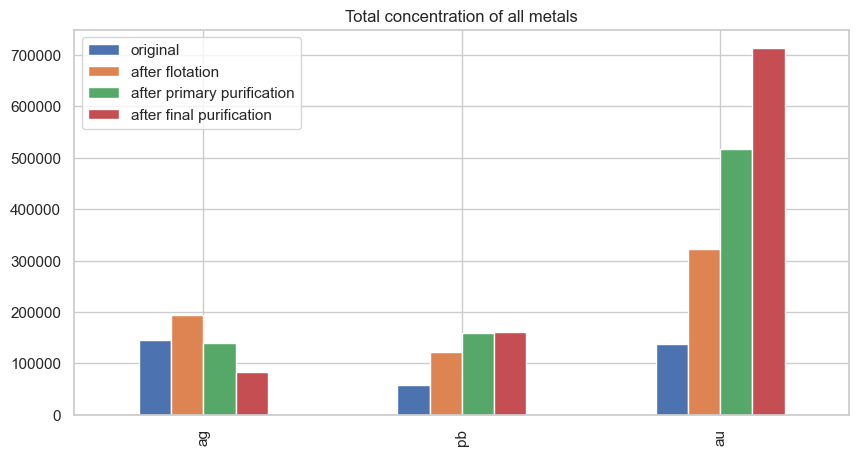

In [64]:
l = ['rougher.input.feed_','rougher.output.concentrate_','primary_cleaner.output.concentrate_','final.output.concentrate_']
metal_list = ['ag','pb','au']
name = ['original','after flotation','after primary purification','after final purification']
a = []
for metal in metal_list:   
    for i in l:
        a.append(data_full[[i+metal]].values.sum())
df_sum_con = pd.DataFrame([a[:4],a[4:8],a[8:]],index=metal_list,columns=name)
plt.figure(figsize=(7,4))
df_sum_con.plot(kind='bar',figsize=(10,5))
plt.title('Total concentration of all metals')
plt.show()

In [63]:
df_sum_con

,original,after flotation,after primary cleaning,after final cleaning
ag,144609.108070,194495.102551,139613.083984,83543.562649
pb,58527.783485,121559.514010,159073.388967,160901.269276
au,137072.441231,322719.333964,516063.108326,713083.897490


**Conclusion: The total concentration increases for gold and lead during the purification process. The final concentration of gold has increased sixfold compared to the initial concentration. The concentration of silver starts decreasing after the flotation stage. After each purification stage, the concentration range narrows, as clearly seen in the graph.**

## Model training

Let's build linear regression and random forest models. Let's start with linear regression, but before that we will set the evaluation function

In [39]:
def smape(predict, target):
    smape =  1 / len(predict) * np.sum((np.abs(target - predict)/ ((np.abs(target) + np.abs(predict)) / 2))) * 100
    return -1 * smape

def modified_smape(rougher: float, final: float):
    return -(0.25 * rougher + 0.75 * final)

smape_scorer = make_scorer(smape, greater_is_better = False)

In [40]:
model_rougher = LinearRegression()
smape_rougher = cross_val_score(model_rougher,
                                features_rougher,
                                target_rougher,
                                scoring=smape_scorer,
                                cv=10)
print("Mean score: ", smape_rougher.mean())
print("Standard deviation: ", smape_rougher.std())

Mean score:  9.718238291533332
Standard deviation:  4.144284228915513


In [41]:
model_final = LinearRegression()
smape_final = cross_val_score(model_final,
                        features,
                        target,
                        scoring=smape_scorer,
                        cv=10)
print("Mean score: ", smape_final.mean())
print("Standard deviation: ", smape_final.std())

Mean score:  8.993167128128476
Standard deviation:  1.3864807538203938


In [42]:
predict_rougher = model_rougher.fit(features_rougher,target_rougher).predict(features_rougher_test)
rougher_smape = smape(predict_rougher, target_rougher_test)
print(-rougher_smape)

rougher.output.recovery    9.318011
dtype: float64


In [43]:
predict = model_final.fit(features,target).predict(features_test)
final_smape = smape(predict, target_test)
print(-final_smape)

final.output.recovery    8.44116
dtype: float64


In [44]:
modified_smape(rougher_smape[0], final_smape[0])

8.66037279348756

Conclusion: The linear regression model yielded SMAPE score of approximately 8.7. It is logical that the predictions for the flotation stage are less accurate due to the smaller number of features available.

*Ler's train RandomForest*

In [70]:
%%time
m1 = RandomForestRegressor(random_state=123)
parameters = {'n_estimators':range(10,100,10), 'max_depth':range(3,10,2)}
gs_f1 = GridSearchCV(m1,
                     parameters,
                     scoring=smape_scorer,
                     n_jobs=-1
                    )
gs_f1.fit(features_rougher, target_rougher)
gs_f1.best_params_

CPU times: total: 1.8 s
Wall time: 4min 26s


{'max_depth': 3, 'n_estimators': 10}

In [71]:
model = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=123)
predict = model.fit(features_rougher,target_rougher).predict(features_rougher_test)
rougher_smape_rf = smape(predict, target_rougher_test['rougher.output.recovery'])
print('SMAPE before flotation')
print(-rougher_smape_rf)
predict = model.fit(features,target).predict(features_test)
final_smape_rf = smape(predict, target_test['final.output.recovery'])
print('SMAPE after final cleaning')
print(-final_smape_rf)

SMAPE before flotation
10.439827744306301
SMAPE after final cleaning
7.609863008405658


In [72]:
round(modified_smape(rougher_smape_rf,final_smape_rf),2)

8.32

Conclusion: The SMAPE score for the random forest model is significantly worse for flotation at 10.4. However, due to its better performance for the final cleaning stage at 7.6%, the overall SMAPE score is also 8.3%. Therefore, we will use a linear regressor for the first stage of cleaning and the random forest for the final stage. Let's calculate the final SMAPE score for this arrangement.

In [73]:
round(modified_smape(rougher_smape,final_smape_rf)[0],2)

8.04

*Check adequacy of the model*

In [76]:
dummy_model = DummyRegressor(strategy="mean")
predict_dummy = model.fit(features_rougher,target_rougher).predict(features_rougher_test)
dummy_rougher_smape_rf = smape(predict_dummy, target_rougher_test['rougher.output.recovery'])
print('SMAPE, flotation')
print(-dummy_rougher_smape_rf)
predict_dummy = dummy_model.fit(features,target).predict(features_test)
dummy_final_smape_rf = smape(predict_dummy, target_test['final.output.recovery'])
print('SMAPE, final purification')
print(-dummy_final_smape_rf)

SMAPE, flotation
10.439827744306301
SMAPE, final purification
9.56858357360044


In [75]:
round(modified_smape(dummy_rougher_smape_rf,dummy_final_smape_rf),2)

9.79

**Conclusion: During the project, data preprocessing and analysis were conducted. The investigation of metal concentrations at different stages revealed that the concentration of gold increased from stage to stage, while the distribution narrowed. It is also worth noting the presence of zeros in the dataset, which could indicate the presence of empty ore, data filling errors, or a violation of the chemical process. The most effective approach was found to be the application of linear regression for the flotation stage and random forest for the final cleaning stage**